In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import scipy
import hvplot
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

import warnings

warnings.filterwarnings("ignore")

In [3]:
def get_prep_data(data_file, col_price, index_col):
    data = pd.read_csv(data_file, index_col=index_col, parse_dates=True)
    data.index.name = None
    data = data[[col_price]]
    data = data.asfreq('D')
    data = data.ffill()
    return data

In [4]:
amd = get_prep_data(data_file="amd_prep.csv", col_price='close_price', index_col="date")
intel = get_prep_data(data_file="intel_prep.csv", col_price='close_price', index_col="date")

In [5]:
intel['1stdiff'] = intel['close_price'].diff()
intel['LogPassengers'] = np.log(intel['close_price'])
intel['LogReturns'] = np.log(intel['close_price']).diff()

In [6]:
intel

,close_price,1stdiff,LogPassengers,LogReturns
2017-01-03,36.60,NaN,3.600048,NaN
2017-01-04,36.41,-0.19,3.594843,-0.005205
2017-01-05,36.35,-0.06,3.593194,-0.001649
2017-01-06,36.48,0.13,3.596764,0.003570
2017-01-07,36.48,0.00,3.596764,0.000000
...,...,...,...,...
2025-04-20,18.93,0.00,2.940748,0.000000
2025-04-21,18.84,-0.09,2.935982,-0.004766
2025-04-22,19.51,0.67,2.970927,0.034945
2025-04-23,20.59,1.08,3.024806,0.053878


In [7]:
intel_df = pd.DataFrame(intel['close_price'].diff())

In [8]:
model = AutoReg(intel_df.dropna(), lags=1, trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            close_price   No. Observations:                 3033
Model:                     AutoReg(1)   Log Likelihood               -3923.578
Method:               Conditional MLE   S.D. of innovations              0.883
Date:                Thu, 01 May 2025   AIC                           7851.155
Time:                        13:04:19   BIC                           7863.189
Sample:                    01-05-2017   HQIC                          7855.481
                         - 04-24-2025                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
close_price.L1    -0.0956      0.018     -5.288      0.000      -0.131      -0.060
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.4592           +0.0000j           10.4592            0.5000
-----------------------------------------------------------------------------
"""

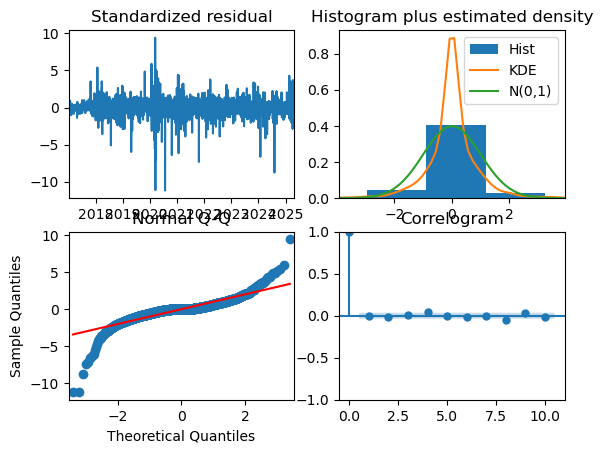

In [9]:
model.plot_diagnostics()
plt.show()

In [10]:
model.test_normality()

Jarque-Bera    59392.606337
P-value            0.000000
Skewness          -1.231731
Kurtosis          24.541995
dtype: float64

После редыдущего блока было много кода с ARIMA, но к удовлетвортительному результату я так и не пришёл.
Так же пробовал ARCH но он так же не показал достойного результата.
После я опробовал Prophet, который показал достаточно неплохой результат при низких трудозатратах.

# Prophet

In [14]:
from prophet import Prophet

In [15]:
df = pd.DataFrame(intel['close_price'].reset_index())
df.columns = ['ds', 'y']
df

,ds,y
0,2017-01-03,36.60
1,2017-01-04,36.41
2,2017-01-05,36.35
3,2017-01-06,36.48
4,2017-01-07,36.48
...,...,...
3029,2025-04-20,18.93
3030,2025-04-21,18.84
3031,2025-04-22,19.51
3032,2025-04-23,20.59


In [16]:
predictions = 50
train_df = df[:-predictions]

In [17]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train_df)

# создаём ещё один специальный датафрейм для предсказаний
# здесь также необходимо указать частоту данных (по умолчанию — дни)
future = model.make_future_dataframe(periods=predictions, freq='D')
future.tail()

13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing


,ds
3029,2025-04-20
3030,2025-04-21
3031,2025-04-22
3032,2025-04-23
3033,2025-04-24


In [18]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3029,2025-04-20,19.094645,17.948161,26.865567,18.872062,19.295544,3.472550,3.472550,3.472550,-0.036162,-0.036162,-0.036162,3.508712,3.508712,3.508712,0.0,0.0,0.0,22.567195
3030,2025-04-21,19.058356,18.098924,26.693837,18.813692,19.269339,3.360708,3.360708,3.360708,0.014273,0.014273,0.014273,3.346435,3.346435,3.346435,0.0,0.0,0.0,22.419064
3031,2025-04-22,19.022067,17.818245,26.555880,18.757873,19.242723,3.201066,3.201066,3.201066,0.023685,0.023685,0.023685,3.177381,3.177381,3.177381,0.0,0.0,0.0,22.223133
3032,2025-04-23,18.985778,17.098954,26.793613,18.691694,19.215543,3.035492,3.035492,3.035492,0.032874,0.032874,0.032874,3.002618,3.002618,3.002618,0.0,0.0,0.0,22.021270
3033,2025-04-24,18.949489,17.503086,26.352585,18.649197,19.186513,2.868744,2.868744,2.868744,0.045518,0.045518,0.045518,2.823226,2.823226,2.823226,0.0,0.0,0.0,21.818233


In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Оценим качество модели

Mean absolute percentage error 12.16%


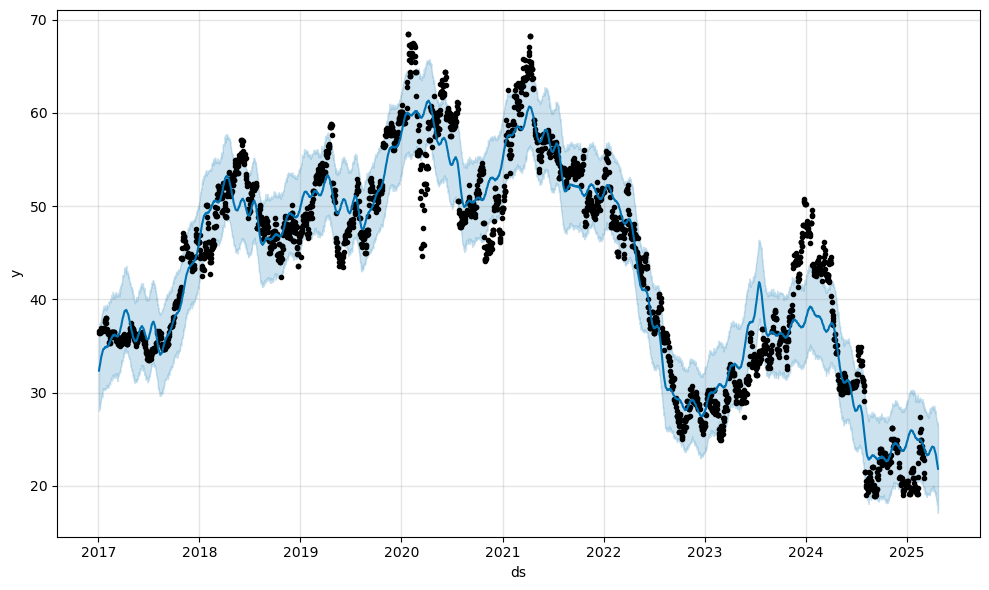

In [21]:
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)
plt.show()

##### Итого мы получаем MAPE 12% при прогнозировании на 50 дней, в принципе это не так и плохо.

In [23]:
import hvplot

hvplot.plot(forecast[['ds', 'yhat']], kind='line', width=800, height=400, grid=True)

:Curve   [index]   (yhat)

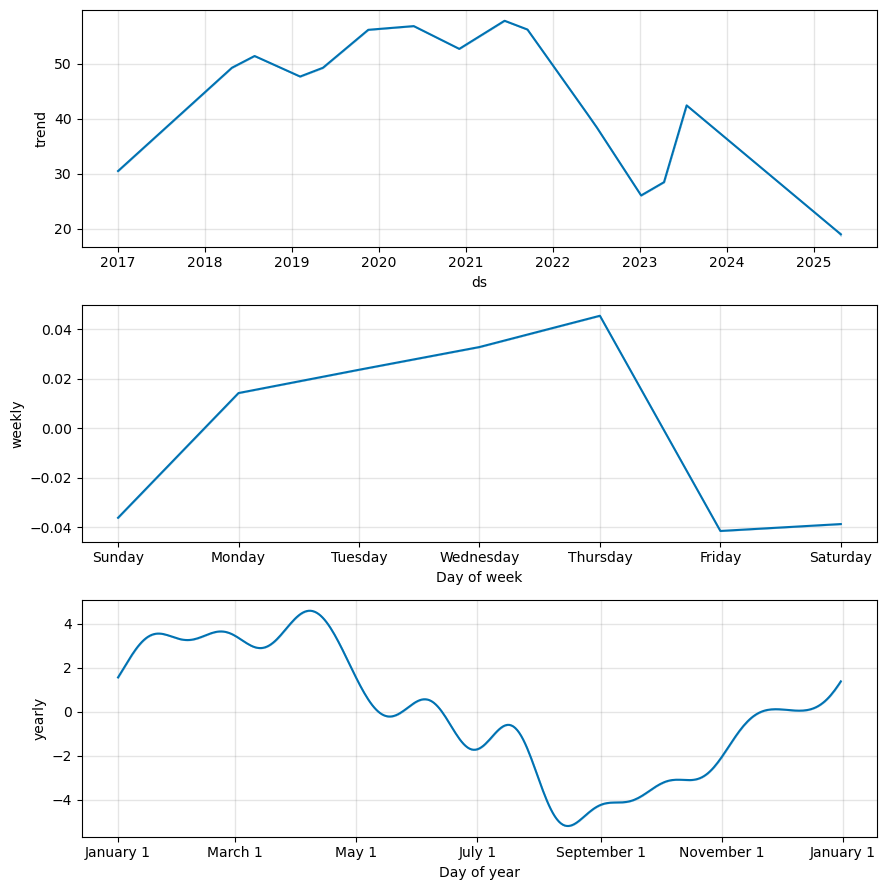

In [24]:
fig2 = model.plot_components(forecast)
plt.show()

### Заметка.
Интересно отметить что начало падения акций интел пришлось на 2021 год, в конце 2020 компания Apple представила свой чип M1, который в будущем заменил чипы интел в собственных ноутбуках. После, в конце 2020 и начале 2021 выходили новые модели с чипом М1. Судя по всему рынок некоторое время тестировал новые ноутбуки с собственным процессором и затем акции пошли вниз.

А теперь пробуем прогнозировать на 1, 3, 6 и 12 месяцев

In [26]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, 
                weekly_seasonality = True, 
                daily_seasonality = True)
model.fit(df)

future_months = model.make_future_dataframe(periods=30, freq='d')
future_quarter = model.make_future_dataframe(periods=3, freq='m')
future_half_year = model.make_future_dataframe(periods=6, freq='m')
future_year = model.make_future_dataframe(periods=1, freq='y')

forecast_months = model.predict(future_months)
forecast_quarter = model.predict(future_quarter)
forecast_half_year = model.predict(future_half_year)
forecast_year = model.predict(future_year)

13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:26 - cmdstanpy - INFO - Chain [1] done processing


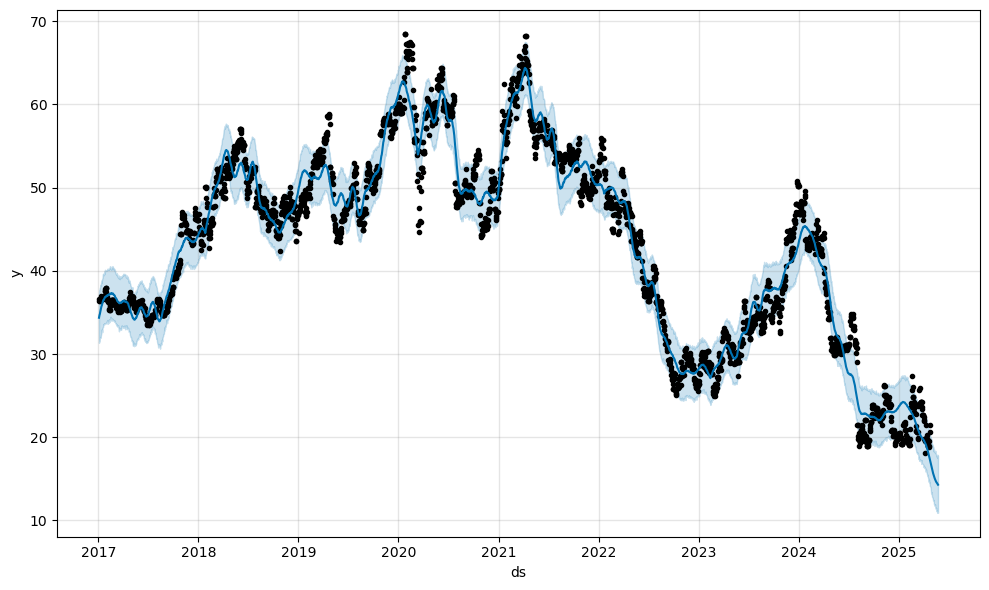

In [27]:
fig = model.plot(forecast_months)
plt.show()

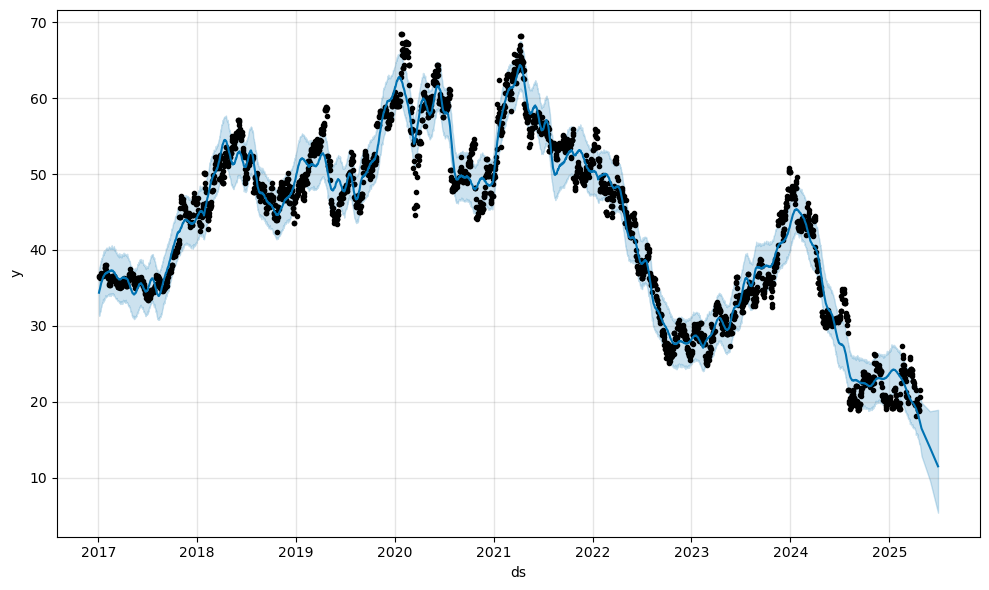

In [28]:
fig = model.plot(forecast_quarter)
plt.show()

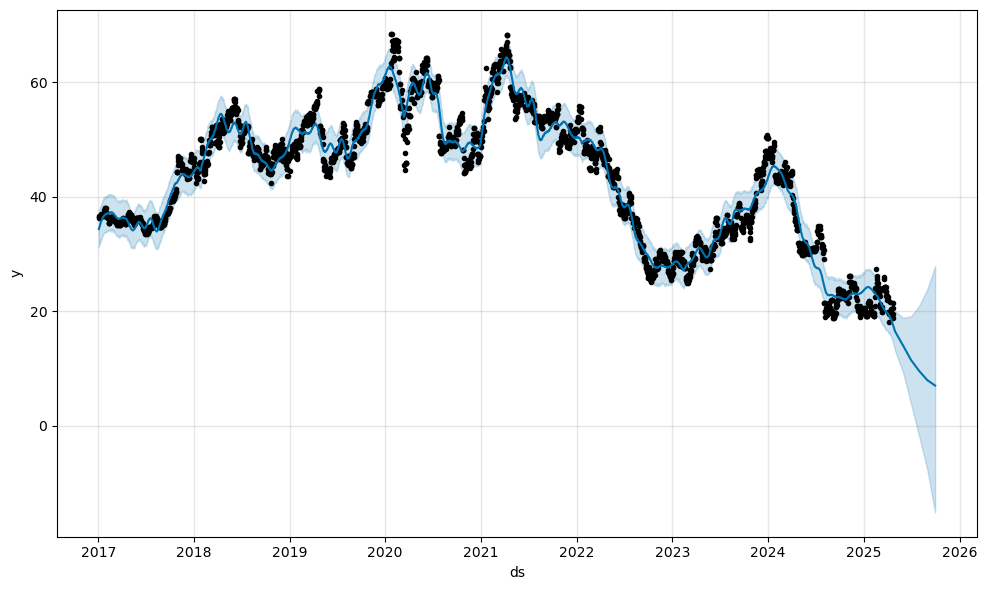

In [29]:
fig = model.plot(forecast_half_year)
plt.show()

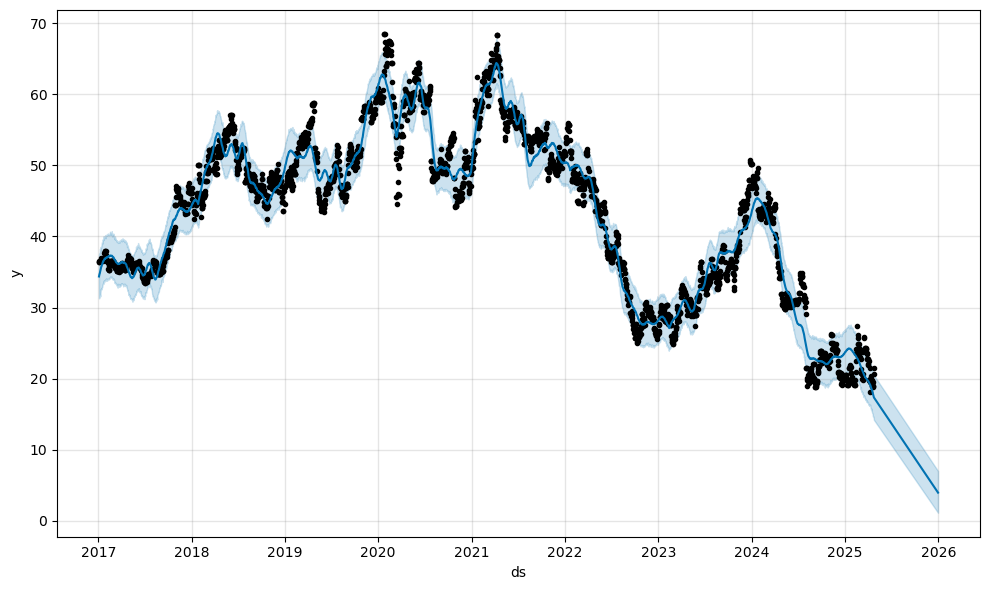

In [30]:
fig = model.plot(forecast_year)
plt.show()

# Вывод.
Прогноизрование на длительный срок - дело не благодарное, как минимум в разрезе акций особенно это показывает граффики на пол года и год, если на пол года модель допускает корреляцию в каких то пределах, то годовое предсказание - тоннельное падение акций вниз, что вряд ли будет в реальности. В целом библиотека Prophet достаточно проста в использовании и показывает неплохой результат. 
### Вывод по исследованию акций Intel
Судя по графику у наблюдается денденция на спад цены акций в долгосрочной перспективе, этот тренд заметен на протяжении последних лет, и модель нам это подтверждает, тем интереснее було бы посмотреть на результат прогноза со временем